# Community Finding - Algorithm Comparision
## Jake Carlson

## Load Data

In [1]:
import numpy as np
import pandas as pd
import igraph
import uuid
import matplotlib.pyplot as plt

df_q = pd.read_csv("./data/2008-questions.csv")
df_a = pd.read_csv("./data/2008-answers.csv")
df_t = pd.read_csv("./data/2008-tags.csv")

# remove NaN owner ids
df_q = df_q[np.isfinite(df_q.OwnerUserId.values)]
df_a = df_a[np.isfinite(df_a.OwnerUserId.values) & df_a.ParentId.isin(df_q.Id)]

df_q.OwnerUserId = df_q.OwnerUserId.astype(np.int)
df_a.OwnerUserId = df_a.OwnerUserId.astype(np.int)

df_q['qid'] = [uuid.uuid4() for _ in range(len(df_q))]
df_a['qid'] = [df_q['qid'].values[df_q.Id == a][0] for a in df_a.ParentId.values]

In [2]:
owner_to_uid = {}
def get_uids(df):
    uids = []
    for i, r in df.iterrows():
        owner = r['OwnerUserId']
        uid = None
        if owner in owner_to_uid.keys():
            uid = owner_to_uid[owner]
        else:
            uid = uuid.uuid4()
            owner_to_uid[owner] = uid
        uids.append(uid)
    return uids

df_q['uid'] = get_uids(df_q)
df_a['uid'] = get_uids(df_a)

In [3]:
df_q.head()

,Id,OwnerUserId,CreationDate,Score,Title,qid,uid
0,80,26,2008-08-01T13:57:07Z,26,SQLStatement.execute() - multiple queries in o...,52185a46-67ec-4c8c-880b-4f9284bfbb7c,8b5cf124-c106-467b-b145-5ac10b5a9224
1,90,58,2008-08-01T14:41:24Z,144,Good branching and merging tutorials for Torto...,b1cd0f4c-11a7-4f47-9c19-2208628d2465,aee539a2-5e10-4950-b799-232f26279907
2,120,83,2008-08-01T15:50:08Z,21,ASP.NET Site Maps,1fb3cb48-4b8d-4715-91a0-939215712df2,2dc0dc37-8a56-4168-905d-1699b313ec27
3,180,2089740,2008-08-01T18:42:19Z,53,Function for creating color wheels,7b0e45bd-2d69-4419-8a7a-47f80f03078f,b0a25609-4aed-4096-b5e2-373dfd8d2279
4,260,91,2008-08-01T23:22:08Z,49,Adding scripting functionality to .NET applica...,4f648e2b-c003-4b51-a6e3-228e66423050,ca1d0d5e-f8ec-467b-ba14-80ce4146bf36


In [4]:
df_a.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,qid,uid
0,92,61,2008-08-01T14:45:37Z,90,13,b1cd0f4c-11a7-4f47-9c19-2208628d2465,65adeba4-587e-40f8-80ae-2553d1faa688
1,124,26,2008-08-01T16:09:47Z,80,12,52185a46-67ec-4c8c-880b-4f9284bfbb7c,8b5cf124-c106-467b-b145-5ac10b5a9224
2,199,50,2008-08-01T19:36:46Z,180,1,7b0e45bd-2d69-4419-8a7a-47f80f03078f,21fe8356-fe36-4781-a70a-0a01ed1db626
3,269,91,2008-08-01T23:49:57Z,260,4,4f648e2b-c003-4b51-a6e3-228e66423050,ca1d0d5e-f8ec-467b-ba14-80ce4146bf36
4,307,49,2008-08-02T01:49:46Z,260,28,4f648e2b-c003-4b51-a6e3-228e66423050,7ee6ae00-ccf4-4ef7-a6de-a5e1c9fb1fd4


In [5]:
df_t.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [6]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16912 entries, 0 to 16911
Data columns (total 2 columns):
Id     16912 non-null int64
Tag    16912 non-null object
dtypes: int64(1), object(1)
memory usage: 264.3+ KB


In [21]:
df_q.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5299 entries, 0 to 5824
Data columns (total 7 columns):
Id              5299 non-null int64
OwnerUserId     5299 non-null int64
CreationDate    5299 non-null object
Score           5299 non-null int64
Title           5299 non-null object
qid             5299 non-null object
uid             5299 non-null object
dtypes: int64(3), object(4)
memory usage: 491.2+ KB


In [10]:
users_to_questions = {}
for g, data in df_q.groupby(['uid']):
    users_to_questions[g] = set(data.qid.values)
for g, data in df_a.groupby(['uid']):
    if g in users_to_questions.keys():
        users_to_questions[g].update(data.qid.values)
    else:
        users_to_questions[g] = set(data.qid.values)

In [11]:
users = list(users_to_questions.keys())
questions = list(set([j for i in users_to_questions.values() for j in list(i)]))

In [12]:
users_to_idx = {}
for k, v in users_to_questions.items():
    users_to_idx[k] = [questions.index(q) for q in list(v)]

In [13]:
types = [1 for u in users] + [0 for q in questions]
edges = []
offset = len(users)
for i, u in enumerate(users):
    for j in users_to_idx[u]:
        edges.append((i, offset + j))

In [14]:
graph = igraph.Graph.Bipartite(types, edges)
graph.vs['name'] = users + questions

In [15]:
print(graph)

IGRAPH UN-T 13492 23525 --
+ attr: name (v), type (v)
+ edges (vertex names):
0006092f-9515-4bf1-b0df-6a5c3b071a1d--98ba91fe-5ad7-4523-82fe-c522e081ae5e,
0006092f-9515-4bf1-b0df-6a5c3b071a1d--9cb1e22b-ef56-432f-95df-34e356f477ff,
0006092f-9515-4bf1-b0df-6a5c3b071a1d--d1a27494-a9cc-4ba9-a014-ac8b00e877e1,
0006092f-9515-4bf1-b0df-6a5c3b071a1d--d70c0ade-2aa0-4344-8406-9c183e936a71,
0006092f-9515-4bf1-b0df-6a5c3b071a1d--493fc30e-a302-4869-890a-2edff1e59c32,
0006092f-9515-4bf1-b0df-6a5c3b071a1d--0f37c4df-f1b6-4c43-86a6-23319a448e55,
0006092f-9515-4bf1-b0df-6a5c3b071a1d--6ee316a7-ec6f-4586-9217-6f3c10fb3769,
0006092f-9515-4bf1-b0df-6a5c3b071a1d--6ed37c31-716b-46e2-b0c9-8f703abe23eb,
002af8ac-3fc2-4937-a416-11d97e145e6b--7c347d6e-576a-42a4-bc3e-a9e8a6fb08ac,
003592a5-96b1-452c-8f86-44db6ba076e7--a46d580a-8f93-4eec-9e81-6bdfeae54b82,
0042f1d2-cc0e-46b0-bcf2-58be7a07cc8e--ebceccc3-1fc2-4ecc-b649-6ac32aa5ef01,
0042f1d2-cc0e-46b0-bcf2-58be7a07cc8e--3ea1a7a6-a6a8-4acd-be7e-3260bfe7b239,
00436472-3

In [8]:
def get_largest_component(g):
    comps = g.components()
    sizes = comps.sizes()
    idx_largest = sizes.index(max(sizes))
    return comps.subgraph(idx_largest)

In [17]:
largest = get_largest_component(graph)

In [18]:
largest

## Walktrap

In [14]:
dendrogram = largest.community_walktrap()
dendrogram.optimal_count

74

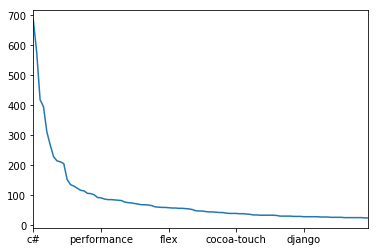

In [52]:
tag_counts = df_t.Tag.value_counts()
tag_counts[:100].plot()
plt.show()

In [58]:
n_clusters = sum(tag_counts > 100)
n_clusters

19

In [15]:
clusters = dendrogram.as_clustering()
membership = clusters.membership

In [22]:
qids = set(list(df_q.qid.values))
def get_n_tag_counts_for_membership(m, n):
    q_ids = qids.intersection(set([graph.vs[i]['name'] for i in range(len(largest.vs)) if membership[i] == m]))
    q_tags = df_t.Tag[df_t.Id.isin(df_q.Id[df_q.qid.isin(q_ids)])]
    return len(q_ids), q_tags.value_counts()

In [23]:
for m in list(set(membership)):
    num, counts = get_n_tag_counts_for_membership(m, 5)
    print(m, ":", num)
    print(counts)

0 : 0
Series([], Name: Tag, dtype: int64)
1 : 0
Series([], Name: Tag, dtype: int64)
2 : 0
Series([], Name: Tag, dtype: int64)
3 : 0
Series([], Name: Tag, dtype: int64)
4 : 0
Series([], Name: Tag, dtype: int64)
5 : 0
Series([], Name: Tag, dtype: int64)
6 : 0
Series([], Name: Tag, dtype: int64)
7 : 0
Series([], Name: Tag, dtype: int64)
8 : 0
Series([], Name: Tag, dtype: int64)
9 : 0
Series([], Name: Tag, dtype: int64)
10 : 0
Series([], Name: Tag, dtype: int64)
11 : 0
Series([], Name: Tag, dtype: int64)
12 : 0
Series([], Name: Tag, dtype: int64)
13 : 0
Series([], Name: Tag, dtype: int64)
14 : 0
Series([], Name: Tag, dtype: int64)
15 : 0
Series([], Name: Tag, dtype: int64)
16 : 0
Series([], Name: Tag, dtype: int64)
17 : 0
Series([], Name: Tag, dtype: int64)
18 : 0
Series([], Name: Tag, dtype: int64)
19 : 0
Series([], Name: Tag, dtype: int64)
20 : 0
Series([], Name: Tag, dtype: int64)
21 : 0
Series([], Name: Tag, dtype: int64)
22 : 0
Series([], Name: Tag, dtype: int64)
23 : 0
Series([], Nam

In [ ]:
palette = igraph.drawing.colors.ClusterColoringPalette(len(clusters))
colors = palette.get_many(membership)

# set user colors (r, b, g, a)
# for i in range(len(users)):
#     colors[i] = (1.0, 1.0, 1.0, 1.0)
# for i in range(len(questions)):
#     colors[offset+i] = (1.0, 0.0, 0.0, 1.0)
largest.vs['color'] = colors
igraph.plot(largest, opacity=0.5)

## Spinglass

In [67]:
clustering = largest.community_spinglass()
membership = clustering.membership

In [68]:
for m in list(set(membership)):
    num, counts = get_n_tag_counts_for_membership(m, 5)
    print(m, ":", num)
    print(counts)

0 : 121
.net       19
c#         15
c++        10
asp.net     8
java        8
Name: Tag, dtype: int64
1 : 109
c#         10
java       10
php         9
asp.net     8
.net        7
Name: Tag, dtype: int64
2 : 152
c#            26
.net          19
java          15
asp.net       13
javascript    10
Name: Tag, dtype: int64
3 : 123
c#            14
javascript    10
c++            9
.net           9
java           8
Name: Tag, dtype: int64
4 : 444
c#         51
.net       50
java       33
asp.net    32
sql        30
Name: Tag, dtype: int64
5 : 525
c#            62
.net          56
asp.net       38
java          32
javascript    30
Name: Tag, dtype: int64
6 : 151
c#         18
asp.net    14
.net       12
c++        11
java       10
Name: Tag, dtype: int64
7 : 379
.net       36
c#         29
java       27
asp.net    25
c++        20
Name: Tag, dtype: int64
8 : 106
c#               14
.net             10
visual-studio     7
python            7
vb.net            6
Name: Tag, dtype: int64
9 : 381

In [ ]:
palette = igraph.drawing.colors.ClusterColoringPalette(len(set(membership)))
colors = palette.get_many(membership)

# set user colors (r, b, g, a)
# for i in range(len(users)):
#     colors[i] = (1.0, 1.0, 1.0, 1.0)
# for i in range(len(questions)):
#     colors[offset+i] = (1.0, 0.0, 0.0, 1.0)
largest.vs['color'] = colors
igraph.plot(largest, opacity=0.5)

## Questions Only

In [9]:
tags_to_questions = {}
for g, data in df_t.groupby(['Tag']):
    tags_to_questions[g] = set(map(str, df_q.qid[df_q.Id.isin(data.Id)].values))

questions_to_questions = {}
for t, quids in tags_to_questions.items():
    for i, q in enumerate(quids):
        if q in questions_to_questions.keys():
            questions_to_questions[q].update(quids)
        else:
            questions_to_questions[q] = set(quids)
        questions_to_questions[q].remove(q)

questions = list(map(str, questions_to_questions.keys()))
questions_to_idx = {}
for i, q in enumerate(questions):
    questions_to_idx[q] = i

In [10]:
edges = []
for k, v in questions_to_questions.items():
    for q in v:
        edges.append((questions_to_idx[k], questions_to_idx[q]))

In [11]:
graph = igraph.Graph(edges=edges)
graph.vs['name'] = questions

In [12]:
largest = get_largest_component(graph)